### This python code is for independent test, auROC  curves,  Precisino-Recall curve, and AUC values   with label data for both human and plant (papaya) data 

### Importing the python libraries

In [1]:
from keras import backend as K
import tensorflow as tf
from keras import initializers,layers,regularizers
from keras.layers import Dropout
from keras import callbacks
from keras.models import *
from keras.engine.topology import Layer
from keras.callbacks import EarlyStopping
from keras.layers import Dropout,Activation
import numpy as np
from keras import optimizers
from Bio import SeqIO
from sklearn.model_selection import train_test_split
import keras
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy import interp
from keras.regularizers import l2
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU,BatchNormalization,Concatenate
from sklearn.manifold import TSNE
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
import sys
print(sys.version) # python version

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [3]:
import keras
keras.__version__ # keras version

'2.2.4'

### One-hot encoding or binary encoding for each amino acids

In [15]:
def onehot(seq):
    bases = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    X = np.zeros((len(seq),len(seq[0]),len(bases)))
    for i,m in enumerate(seq):
        for l,s in enumerate(m):
    #         print(s)
            if s in bases:
                X[i,l,bases.index(s)] = 1
    return X

### Function to read a fasta file

In [16]:
def read_fasta(file_path):
    '''File_path: Path to the fasta file
       Returns: List of sequence
    '''
    one=list(SeqIO.parse(file_path,'fasta'))
    return one

### capsul network codes start from here

Our Capsnets code is modified version and origin is based on the keras implementation of CapsuleNet by Xifeng by Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras

In [10]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """

    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

### Squash activation for   Equation 3,  described  in the  manuscript

In [11]:
def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [12]:
class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """

    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(
            shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
            initializer=self.kernel_initializer,
            name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """
        # Begin: inputs_hat computation V1 ---------------------------------------------------------------------#
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # w_tiled.shape = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        # End: inputs_hat computation V1 ---------------------------------------------------------------------#
        """

        # Begin: inputs_hat computation V2 ---------------------------------------------------------------------#
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        # End: inputs_hat computation V2 ---------------------------------------------------------------------#
        """
        # Begin: routing algorithm V1, dynamic ------------------------------------------------------------#
        def body(i, b, outputs):
            c = tf.nn.softmax(b, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            if i != 1:
                b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]
        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        shape_invariants = [tf.TensorShape([]),
                            tf.TensorShape([None, self.input_num_capsule, self.num_capsule, 1, 1]),
                            tf.TensorShape([None, 1, self.num_capsule, 1, self.dim_vector])]
        _, _, outputs = tf.while_loop(cond, body, loop_vars, shape_invariants)
        # End: routing by aggrement  algorithm 1, dynamic ------------------------------------------------------------#
        """

        # Begin: routing algorithm V2, static -----------------------------------------------------------#
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)
            
            # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
                # tf.summary.histogram('BigBee', self.bias)  # for debugging
        # End: routing algorithm V2, static ------------------------------------------------------------#

        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


In [13]:
def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv1D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv1D(filters=dim_vector * n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv1d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [14]:
def CapsNet(input_shape, n_class, num_routing):

    x = layers.Input(shape=input_shape)
    conv1 = layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='valid', activation='relu', name='conv1')(x)
    conv1=Dropout(0.7)(conv1)
    lstm = layers.LSTM(units=128,   name='Lstm',  return_sequences=True)(conv1)
    # Layer 2: Conv1D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(lstm, dim_vector=8, n_channels=16, kernel_size=3, strides=1, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    KcrCaps = CapsuleLayer(num_capsule=n_class, dim_vector=8, num_routing=num_routing, name='KcrCaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out = Length(name='capsnet')(KcrCaps)
    #model
    train_model = Model(x, out)
    return train_model

In [17]:
def margin_loss(y_true, y_pred):
    """
     When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

### Our DeepCap-Kcr model

In [28]:
#31 is length of each sequence and 20 is the one-hot encoding vector for each amino acids, which means we used 31 lenthg of sequence
import warnings
mode1= CapsNet(input_shape=(31,20),n_class=2,num_routing=3)
mode1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 31, 20)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 25, 32)            4512      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 32)            0         
_________________________________________________________________
Lstm (LSTM)                  (None, 25, 128)           82432     
_________________________________________________________________
primarycap_conv1d (Conv1D)   (None, 23, 128)           49280     
_________________________________________________________________
primarycap_reshape (Reshape) (None, 368, 8)            0         
_________________________________________________________________
primarycap_squash (Lambda)   (None, 368, 8)            0         
__________

#### use independent data from human as described in manuscript

In [17]:
positive_ind_data=read_fasta('pos_ind_testdata.txt')
negative_ind_data=read_fasta('neg_ind_testdata.txt')
all_ind_data=positive_ind_data+negative_ind_data

In [18]:
all_ind_onehot=onehot(all_ind_data)

In [30]:
label_ind=len(positive_ind_data)*[1]+ len(negative_ind_data)*[0]
label_ind=np.asarray(label_ind)

#### function for ROC AUC curve and Presicion- Recall curve

In [41]:
def ROC(temp, OutputDir):
    validation_result = temp;
    for x in [validation_result]:

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        i = 0
        for val in x:
            tpr = val['tpr']
            fpr = val['fpr']
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.4f)' % (i+1, roc_auc))

            i += 1

        print;

        plt.plot([0, 1], [0, 1], linestyle='--', lw=1,color='c' , alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.4f)' % (mean_auc, std_auc),
                 lw=1, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate',fontweight='bold')
        plt.ylabel('True Positive Rate',fontweight='bold')
        plt.legend(loc="lower right")
       # plt.savefig( OutputDir + '/'+'roc_capsulnet_independet.pdf') #save the figure in your file path
        plt.show()
        plt.close('all')
        
        
         #************************** Precision Recall Curve*********************************
        j=0
        prs = []
        pre_aucs = []
        mean_recal= np.linspace(0, 1, 100)
        for val in x:
            pre = val['prec']
            rec = val['reca']
            prs.append(interp(mean_recal, rec, pre))
            prs[-1][0] = 0.0
            p_r_auc = auc(rec, pre)
            pre_aucs.append(p_r_auc)
            plt.plot(rec, pre, lw=1, alpha=0.3,label='PRC fold %d (AUC = %0.3f)' % (j+1, p_r_auc))

            j += 1

        print;

        #plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)

        mean_pre = np.mean(prs, axis=0)
        mean_pre[-1] = 1.0
        mean_auc = auc(mean_recal, mean_pre)
        std_auc = np.std(pre_aucs)
        plt.plot(mean_recal, mean_pre, color='b',
                 label=r'Mean PRC (AUC = %0.2f $\pm$ %0.4f)' % (mean_auc, std_auc),
                 lw=1, alpha=.8)

        std_pre = np.std(prs, axis=0)
        pre_upper = np.minimum(mean_pre + std_pre, 1)
        pre_lower = np.maximum(mean_pre - std_pre, 0)
        plt.fill_between(mean_recal, pre_lower, pre_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([0.0, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Recall',fontweight='bold')
        plt.ylabel('Precision',fontweight='bold')
        plt.title('Prc capsulnet',fontweight='bold')
        plt.legend(loc="lower right")
        #plt.savefig( OutputDir + '/' +'PRC_capsulnet_lstmcaps_ind.pdf') ## save file on your own path
        plt.show()
        plt.close('all')

        
def cal(X,y, model):
    pred_y =  model.predict(X)[::,1]
    ROCArea = roc_auc_score(y, pred_y)
    print(ROCArea)
    fpr, tpr, thresholds = roc_curve(y, pred_y)
    lossValue = None
    
    pre, rec, threshlds = precision_recall_curve(y, pred_y)
    pre = np.fliplr([pre])[0]  #so the array is increasing (you won't get negative AUC)
    rec = np.fliplr([rec])[0]  
    AUC_prec_rec = np.trapz(rec,pre)
    AUC_prec_rec = abs(AUC_prec_rec)
    
    
    return { 'fpr' : fpr, 'tpr' : tpr, 'thresholds' : thresholds,'pre_recall_curve':AUC_prec_rec,'prec':pre,'reca':rec}

#### plot AUROC curves and  calculate AUC values, PR curve 

0.9101260773163917
0.9076243202884762
0.9093410532496704
0.9104184955632456
0.9114354954449351


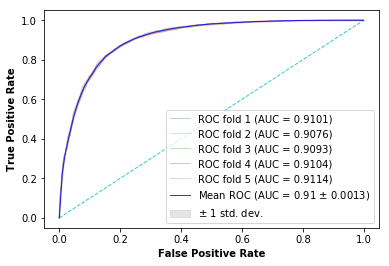

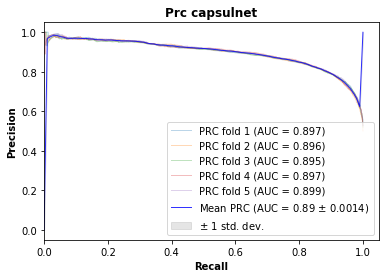

In [42]:
import warnings
warnings.filterwarnings("ignore")
OutputDir="/home/jk/KCR_site_capsule_net" # give your own path in your personal computer
validation_result=[]
for i in range(5):
        mode1.load_weights(str(i+0)+'Lastepoch_new'+'.h5') # load model weights for five folds
        validation_result.append(cal(all_ind_onehot,label_ind, mode1))
        #validation_result.append(cal(data_papaya,training_label[:,1], mode1))
temp_dict = (validation_result)
ROC(temp_dict, OutputDir) 

#### Independent test on plant (papaya) data

In [54]:
pos_papaya=read_fasta('/home/jk/KCR_site_capsule_net/papaya/papaya_31_pos.txt') # load data from your own path 
neg_papaya=read_fasta('/home/jk/KCR_site_capsule_net/papaya/papaya_31_neg.txt')
data_papaya=pos_papaya+neg_papaya

In [59]:
data_papaya=onehot(data_papaya)

In [60]:
label_papaya= len(pos_papaya)*[1]+len(neg_papaya)*[0]
label_papaya=np.asarray(label_papaya)

#### plot AUROC curves and  calculate AUC values, PR curve for papaya data

0.8146211309388269
0.8207935883703792
0.8246960193350633
0.8329708889611849
0.8208002141034347


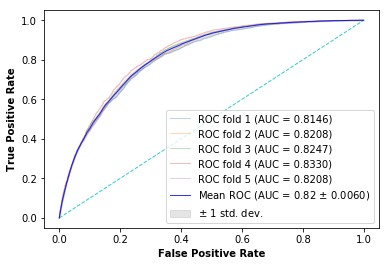

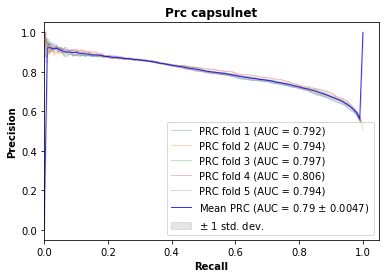

In [61]:
import warnings
warnings.filterwarnings("ignore")
OutputDir="/home/jk/KCR_site_capsule_net" # give your own path in your personal computer
validation_result=[]
for i in range(5):
        mode1.load_weights(str(i+0)+'Lastepoch_new'+'.h5') # load model weights for five folds
        validation_result.append(cal(data_papaya,label_papaya, mode1))
        #validation_result.append(cal(data_papaya,training_label[:,1], mode1))
temp_dict = (validation_result)
ROC(temp_dict, OutputDir) 